In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [39]:
import awswrangler as wr
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

import warnings

warnings.filterwarnings("ignore")

sns.set_theme()

import itertools
import matplotlib.gridspec as gridspec

from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange, AutoDateLocator

import warnings

warnings.filterwarnings("ignore")
import json
from tsai.all import *
from IPython.display import display, Markdown
import json
# from pandas.io.json import json_normalize

from matplotlib.patches import Patch

import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from helper_functions.data_readers import *

from helper_functions.aggregations import *

### read in data

In [4]:
# Brancol Trips
Brancol1data = get_data(boat="brancol", trip_no=0)
Brancol2data = get_data(boat="brancol", trip_no=1)
Brancol3data = get_data(boat="brancol", trip_no=2)

# ST Patrick Trips
StPatrick1data = get_data(boat="stpatrick", trip_no=0)
StPatrick2data = get_data(boat="stpatrick", trip_no=1)

{'trip_id': 'brancol_2024-01-05', 'trip_start_date': '2024-01-05', 'trip_end_date': '2024-01-26'}
{'trip_id': 'brancol_2024-02-03', 'trip_start_date': '2024-02-03', 'trip_end_date': '2024-02-26'}
{'trip_id': 'brancol_2024-03-05', 'trip_start_date': '2024-03-05', 'trip_end_date': '2024-04-01'}
{'trip_id': 'stpatrick_2024-01-03', 'trip_start_date': '2024-01-03', 'trip_end_date': '2024-01-28'}
{'trip_id': 'stpatrick_2024-02-03', 'trip_start_date': '2024-02-03', 'trip_end_date': '2024-02-28'}


In [5]:
counts_Brancol1 = Brancol1data["all_counts"]
counts_Brancol2 = Brancol2data["all_counts"]
counts_Brancol3 = Brancol3data["all_counts"]

brancol1_elog = Brancol1data["elogs"]
brancol2_elog = Brancol2data["elogs"]
brancol3_elog = Brancol3data["elogs"]

brancol1_bv_sets = Brancol1data["bv_sets"]
brancol2_bv_sets = Brancol2data["bv_sets"]
brancol3_bv_sets = Brancol3data["bv_sets"]

brancol1_bv_set_counts = Brancol1data["bv_set_counts"]
brancol2_bv_set_counts = Brancol2data["bv_set_counts"]
brancol3_bv_set_counts = Brancol3data["bv_set_counts"]

aiCounts_Brancol1 = Brancol1data["ai_sets"]
aiCounts_Brancol2 = Brancol2data["ai_sets"]
aiCounts_Brancol3 = Brancol3data["ai_sets"]

brancol1trip = Brancol1data["trip_info"]
brancol2trip = Brancol2data["trip_info"]
brancol3trip = Brancol3data["trip_info"]

In [6]:
counts_StPatrick1 = StPatrick1data["all_counts"]
counts_StPatrick2 = StPatrick2data["all_counts"]

stpatrick1_elog = StPatrick1data["elogs"]
stpatrick2_elog = StPatrick2data["elogs"]

stpatrick1_bv_set_counts = StPatrick1data["bv_set_counts"]
stpatrick2_bv_set_counts = StPatrick2data["bv_set_counts"]

aiCounts_StPatrick1 = StPatrick1data["ai_sets"]
aiCounts_StPatrick2 = StPatrick2data["ai_sets"]

stpatrick2trip = StPatrick2data["trip_info"]
stpatrick1trip = StPatrick1data["trip_info"]

In [11]:
# vectors = [1,2,3,4,5,6,7]
vectors = [7]
vectorData_Brancol1 = {}
vectorData_Brancol2 = {}
vectorData_Brancol3 = {}

vectorData_StPatrick1 = {}
vectorData_StPatrick2 = {}

for vector in vectors:
    vectorData_Brancol1[f"vector_{vector}"] = get_vector_data("brancol", vector, brancol1trip)
    vectorData_Brancol2[f"vector_{vector}"] = get_vector_data("brancol", vector, brancol2trip)
    vectorData_Brancol3[f"vector_{vector}"] = get_vector_data("brancol", vector, brancol3trip)

    vectorData_StPatrick1[f"vector_{vector}"] = get_vector_data("stpatrick", vector, stpatrick1trip)
    vectorData_StPatrick2[f"vector_{vector}"] = get_vector_data("stpatrick", vector, stpatrick2trip)

In [13]:
vector7_brancol1 = vectorData_Brancol1["vector_7"]
vector7_brancol1["datetime"] = pd.to_datetime(vector7_brancol1["datetime"])

vector7_brancol2 = vectorData_Brancol2["vector_7"]
vector7_brancol2["datetime"] = pd.to_datetime(vector7_brancol2["datetime"])

vector7_brancol3 = vectorData_Brancol3["vector_7"]
vector7_brancol3["datetime"] = pd.to_datetime(vector7_brancol3["datetime"])

vector7_stpatrick1 = vectorData_StPatrick1["vector_7"]
vector7_stpatrick1["datetime"] = pd.to_datetime(vector7_stpatrick1["datetime"])

vector7_stpatrick2 = vectorData_StPatrick2["vector_7"]
vector7_stpatrick2["datetime"] = pd.to_datetime(vector7_stpatrick2["datetime"])

### helper functions

##### data prep

In [14]:
def get_ai_counts_elog(ai_counts, elog_hauls):
    conn = sqlite3.connect(":memory:")

    # write the tables to add set_number
    ai_counts.to_sql("ai_counts", conn, index=False)
    elog_hauls.to_sql("hauls", conn, index=False)

    query = """
    select
    distinct
    ai_counts.*,
    hauls.id as elog_id,
    hauls.id is not null as elog_haul
    from ai_counts
    left join hauls on ai_counts.utc_start_datetime between hauls.systemstarthauldatetime and hauls.systemendhauldatetime and hauls.id!= '140'

    """
    ai_counts_elog = pd.read_sql_query(query, conn)

    ai_counts_elog["utc_end_datetime"] = pd.to_datetime(ai_counts_elog["utc_end_datetime"])
    ai_counts_elog["utc_start_datetime"] = pd.to_datetime(ai_counts_elog["utc_start_datetime"])

    elog_hauls["network_delay"] = elog_hauls["datetime"] - elog_hauls["systemendhauldatetime"]
    elog_hauls["large_delay"] = elog_hauls["network_delay"] > pd.Timedelta("4 hours")

    return ai_counts_elog, elog_hauls

In [15]:
def identify_excluded_elogs(elog_hauls, df_vector, ai_counts_elog):
    elog_hauls.sort_values(by="systemendhauldatetime", inplace=True)
    df_vector["window_start"] = df_vector["datetime"] - pd.Timedelta("12 hours")

    elog_vectors = {}
    for idx, haul in elog_hauls.iterrows():
        considered_vectors = []
        received = haul["datetime"]
        haul_end = haul["systemendhauldatetime"]
        df_relevant_vectors = df_vector.loc[
            (haul_end < df_vector["datetime"]) & (haul_end > df_vector["window_start"])
        ]
        for idx, vector in df_relevant_vectors.iterrows():
            vector_time = vector["datetime"]
            if received < vector_time:
                considered_vectors.append(vector["id"])
        elog_vectors[haul["id"]] = considered_vectors

    excluded_elogs = [key for key, value in elog_vectors.items() if len(value) == 0]

    ai_counts_elog["unused_elog"] = ai_counts_elog["elog_id"].apply(
        lambda x: True if x in excluded_elogs else False
    )

    return ai_counts_elog, elog_vectors

##### the plot

In [90]:
def annotate_notes(ax, df, text_col="network_delay", text_xy=(4, 4), var=4):
    arrowprops = dict(arrowstyle="->", connectionstyle="arc3,rad=0", color="black")

    annots = []
    bbox_args = dict(boxstyle="round", facecolor="black", alpha=0.35)

    text_x, text_y = text_xy

    for idx, row in df.loc[df["large_delay"]].iterrows():
        # y_var = x_vars[n]
        components = row[text_col].components
        if components.days > 0:
            days = f"{components.days}d "
        else:
            days = ""

        text = f"{days}{components.hours}h delay"
        data_xy = (row["systemendhauldatetime"], 1)

        an = ax.annotate(
            text,
            xy=data_xy,
            xycoords="data",
            xytext=(text_x, text_y),
            textcoords="offset points",
            arrowprops=arrowprops,
            size=9,
            horizontalalignment="left",
            verticalalignment="bottom",
            # bbox = bbox_args,
            color="black",
        )

        annots.append(an)

        text_y += var
        var = var * -1

    return annots

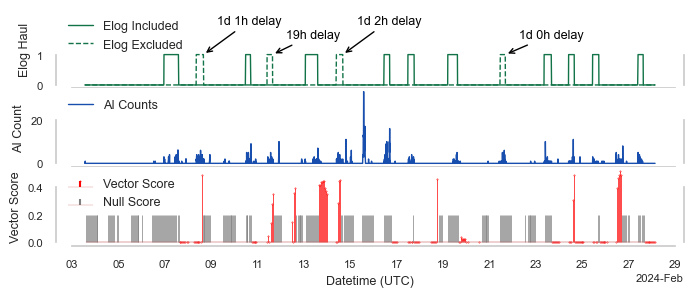

In [94]:
sns.set_style("whitegrid", {"axes.grid": False})
plt.rc("xtick", labelsize=8)
plt.rc("ytick", labelsize=8)
plt.rc("axes", labelsize=9)


def vector_score_plot(
    elog_hauls, ai_counts_elog, catch_col, df_vector, figsize, hpad, savefig=None
):
    bv_color = "#a2c662"
    ai_color = "#184EAD"
    elog_color = "#117347"
    vector_color = "red"

    # predictions_color = '#43aa99'

    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)
    plt.tight_layout()
    plt.subplots_adjust(hspace=hpad)

    ax = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]
    # twin1 = ax.twinx()
    # twin2 = ax.twinx()

    # Offset the right spine of twin2.  The ticks and label have already been
    # placed on the right by twinx above.
    # twin2.spines.right.set_position(("axes", 1.1))
    # twin2.set_ylim(-0.1,2)
    # twin2.set_yticks([0,1])

    annots = annotate_notes(ax, elog_hauls, text_xy=(10, 10), var=10)

    # TOP ax = Elog plot
    sns.lineplot(
        x="utc_start_datetime",
        y="elog_haul",
        data=ai_counts_elog.loc[ai_counts_elog["unused_elog"] == False],
        ax=ax,
        label="Elog Included",
        color=elog_color,
        lw=1,
    )
    sns.lineplot(
        x="utc_start_datetime",
        y="elog_haul",
        data=ai_counts_elog.loc[
            (ai_counts_elog["unused_elog"]) | (ai_counts_elog["elog_haul"] == 0)
        ],
        ax=ax,
        label="Elog Excluded",
        linestyle="--",
        color=elog_color,
        lw=1,
    )
    # sns.lineplot(x = 'utc_start_datetime', y = 'elog_haul', data = ai_counts_elog, ax = ax, label = 'Elog Excluded', linestyle = '--', color =elog_color, lw = 1)
    ax.set_ylabel("Elog Haul")
    ax.set_ylim(-0.1, 2.5)
    ax.set_yticks([0, 1])

    # MIDDLE ax2 = AI catches
    sns.lineplot(
        x="utc_start_datetime",
        y=catch_col,
        data=ai_counts_elog,
        ax=ax2,
        label="AI Counts",
        color=ai_color,
        lw=1,
    )
    ax2.set_ylabel("AI Count")

    # BOTTOM ax3 = vector schore
    # sns.lineplot(x = 'datetime', y= 'score', data = df_vector, ax = ax3, label = 'vector_score', color = vector_color, marker = 'o', markersize = 5, lw = 1)
    ax3.set_ylabel("Vector Score")

    df_vector_nulls = df_vector.loc[df_vector["score"].isna()]

    markerline, stemlines, baseline = ax3.stem(
        df_vector["datetime"], df_vector["score"], linefmt=vector_color, label="Vector Score"
    )
    stemlines.set_linewidths(0.5)
    baseline.set_linewidth(0.2)
    markerline.set_markersize(0.3)

    markerline2, stemlines2, baseline2 = ax3.stem(
        df_vector_nulls["datetime"],
        [0.2] * len(df_vector_nulls),
        linefmt="grey",
        label="Null Score",
    )
    stemlines2.set_linewidths(0.5)
    baseline2.set_linewidth(0.2)
    markerline2.set_markersize(0)

    # ax3.vlines(df_vector_nulls['datetime'], ymin=-.01, ymax=.2, color = 'grey', linewidth = .3)
    ax3.set_ylabel("Vector Score")

    # formatting x axis dates
    locator = DayLocator(interval=2)
    # locator = AutoDateLocator(minticks = 14)
    formatter = mdates.ConciseDateFormatter(locator)
    ax3.xaxis.set_major_locator(locator)
    ax3.xaxis.set_major_formatter(formatter)
    ax3.set_xlabel("Datetime (UTC)")

    # creating legend
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    h3, l3 = ax3.get_legend_handles_labels()
    # line = Line2D([0], [0], color='grey', marker='|',
    #                       markersize=10, markeredgewidth=1.5, label='Vertical line')

    # h3.extend([line])

    # ax.legend(h1+h2+ h3 , l1+l2+ l3, fontsize = 9,loc='upper center', bbox_to_anchor=(1.15, .5), frameon = False)
    ax.legend(frameon=False, fontsize=9)
    ax2.legend(frameon=False, fontsize=9, loc="upper left")
    ax3.legend(frameon=False, fontsize=9)
    # ax3.get_legend().remove()
    # ax2.get_legend().remove()

    sns.despine(
        trim=True,
        right=False,
        # left=True
    )
    if savefig:
        plt.savefig(savefig, bbox_inches="tight", dpi=150)


prep_and_plot(
    ai_counts=aiCounts_StPatrick2,
    elog_hauls=stpatrick2_elog,
    df_vector=vector7_stpatrick2.copy(),
    count_col="overallcatches",
    figsize=(7, 3),
    hpad=0,
    savefig="vector7_stpatrick2.png",
)

In [95]:
1040 / 150

6.933333333333334

In [96]:
446 / 150

2.973333333333333

##### all together now

In [93]:
def prep_and_plot(
    ai_counts, elog_hauls, df_vector, count_col, figsize=(7, 3), hpad=0.5, savefig=None
):
    ai_counts_elog, elog_hauls = get_ai_counts_elog(ai_counts, elog_hauls)
    ai_counts_elog, elog_vectors = identify_excluded_elogs(elog_hauls, df_vector, ai_counts_elog)
    vector_score_plot(
        elog_hauls,
        ai_counts_elog,
        count_col,
        df_vector,
        figsize=figsize,
        hpad=hpad,
        savefig=savefig,
    )

### the plot

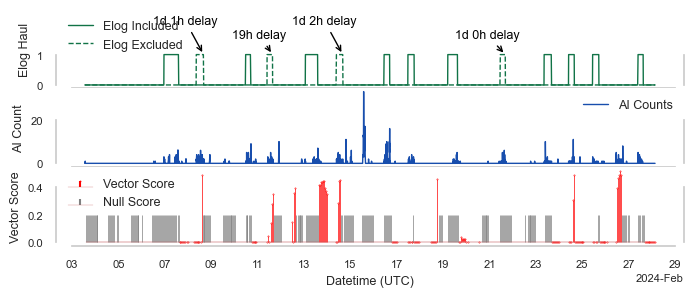

In [87]:
prep_and_plot(
    ai_counts=aiCounts_StPatrick2,
    elog_hauls=stpatrick2_elog,
    df_vector=vector7_stpatrick2.copy(),
    count_col="overallcatches",
    figsize=(7, 3),
    hpad=0,
    savefig="vector7_stpatrick2.png",
)

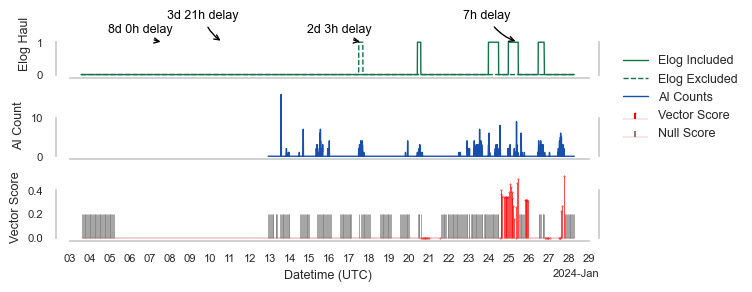

In [24]:
prep_and_plot(
    ai_counts=aiCounts_StPatrick1,
    elog_hauls=stpatrick1_elog,
    df_vector=vector7_stpatrick1.copy(),
    count_col="overallcatches",
    figsize=(7, 3),
)

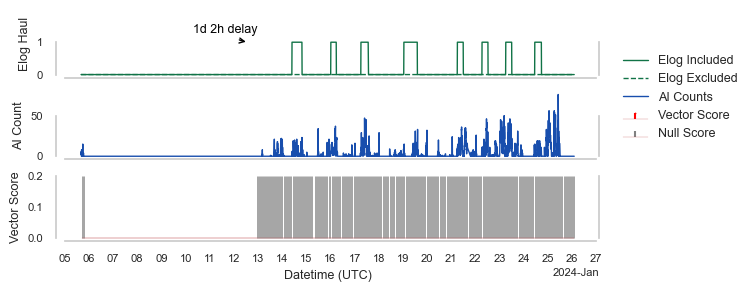

In [21]:
prep_and_plot(
    ai_counts=aiCounts_Brancol1.copy(),
    elog_hauls=brancol1_elog.copy(),
    df_vector=vector7_brancol1.copy(),
    count_col="count",
    figsize=(7, 3),
)

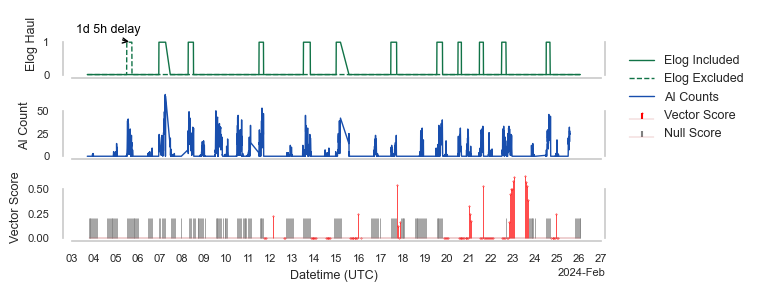

In [22]:
prep_and_plot(
    ai_counts=aiCounts_Brancol2,
    elog_hauls=brancol2_elog,
    df_vector=vector7_brancol2.copy(),
    count_col="count",
    figsize=(7, 3),
)

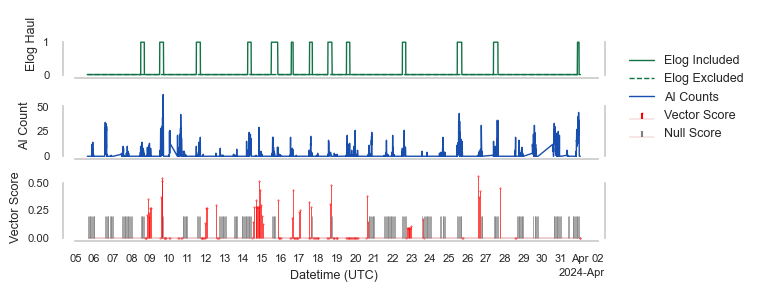

In [23]:
prep_and_plot(
    ai_counts=aiCounts_Brancol3,
    elog_hauls=brancol3_elog,
    df_vector=vector7_brancol3.copy(),
    count_col="count",
    figsize=(7, 3),
)

In [409]:
df_vector_nulls["detail"].value_counts()

detail
elog reports a flat is_fishing variable over time. p_coeff can't work    181
Name: count, dtype: Int64

In [423]:
ai_counts = aiCounts_Brancol2.copy()
elog_hauls = brancol2_elog.copy()
df_vector = vector7_brancol2.copy()
ai_counts_elog, elog_hauls = get_ai_counts_elog(ai_counts, elog_hauls)
ai_counts_elog, elog_vectors = identify_excluded_elogs(elog_hauls, df_vector, ai_counts_elog)

In [424]:
elog_hauls.set_index("id").drop(index="140").head()

,datetime,bycatchcount,catchcount,systemstartsetdatetime,systemendsetdatetime,systemstarthauldatetime,systemendhauldatetime,network_delay,large_delay
id,,,,,,,,,
142,2024-02-06 22:29:05.878725,1,15,2024-02-04 20:56:50.699682,2024-02-05 00:55:06.480773,2024-02-05 11:39:50.504818,2024-02-05 17:15:40.279545,1 days 05:13:25.599180,True
143,2024-02-07 06:03:10.195950,0,44,2024-02-06 11:16:50.109147,2024-02-06 15:07:38.075058,2024-02-06 22:38:41.865946,2024-02-07 06:00:15.813855,0 days 00:02:54.382095,False
145,2024-02-08 12:18:01.426966,1,20,2024-02-07 11:49:53.044018,2024-02-07 15:41:41.659013,2024-02-08 06:34:12.919678,2024-02-08 12:15:14.314220,0 days 00:02:47.112746,False
150,2024-02-11 16:32:12.364133,1,15,2024-02-10 23:05:51.981462,2024-02-11 02:48:33.926947,2024-02-11 11:37:07.875959,2024-02-11 16:31:47.753743,0 days 00:00:24.610390,False
151,2024-02-13 19:31:13.767154,0,19,2024-02-12 18:10:42.436414,2024-02-12 22:22:40.872292,2024-02-13 11:56:59.108003,2024-02-13 19:29:57.253091,0 days 00:01:16.514063,False


In [428]:
df_vector.sort_values("datetime", inplace=True)

In [430]:
df_vector.set_index("datetime").loc["2024-02-07":"2024-02-08"]

,id,score,detail,name,window_start
datetime,,,,,
2024-02-07 02:15:11.454566,26373,<NA>,elog reports a flat is_fishing variable over time. p_coeff can't work,catch count A test from 2024-02-06 02:15 to 2024-02-07 02:15,2024-02-06 14:15:11.454566
2024-02-07 03:15:11.868726,26396,<NA>,elog reports a flat is_fishing variable over time. p_coeff can't work,catch count A test from 2024-02-06 03:15 to 2024-02-07 03:15,2024-02-06 15:15:11.868726
2024-02-07 04:15:12.259390,26419,<NA>,elog reports a flat is_fishing variable over time. p_coeff can't work,catch count A test from 2024-02-06 04:15 to 2024-02-07 04:15,2024-02-06 16:15:12.259390
2024-02-07 05:15:20.144937,26444,<NA>,elog reports a flat is_fishing variable over time. p_coeff can't work,catch count A test from 2024-02-06 05:15 to 2024-02-07 05:15,2024-02-06 17:15:20.144937
2024-02-07 11:59:38.663843,26479,<NA>,elog reports a flat is_fishing variable over time. p_coeff can't work,catch count A test from 2024-02-06 11:59 to 2024-02-07 11:59,2024-02-06 23:59:38.663843
2024-02-07 12:59:39.127262,26502,<NA>,elog reports a flat is_fishing variable over time. p_coeff can't work,catch count A test from 2024-02-06 12:59 to 2024-02-07 12:59,2024-02-07 00:59:39.127262
2024-02-07 13:59:39.514769,26525,<NA>,elog reports a flat is_fishing variable over time. p_coeff can't work,catch count A test from 2024-02-06 13:59 to 2024-02-07 13:59,2024-02-07 01:59:39.514769
2024-02-07 14:59:48.372175,26550,<NA>,elog reports a flat is_fishing variable over time. p_coeff can't work,catch count A test from 2024-02-06 14:59 to 2024-02-07 14:59,2024-02-07 02:59:48.372175
2024-02-07 15:59:48.706923,26573,<NA>,elog reports a flat is_fishing variable over time. p_coeff can't work,catch count A test from 2024-02-06 15:59 to 2024-02-07 15:59,2024-02-07 03:59:48.706923


Text(0, 0.5, 'Vector Score')

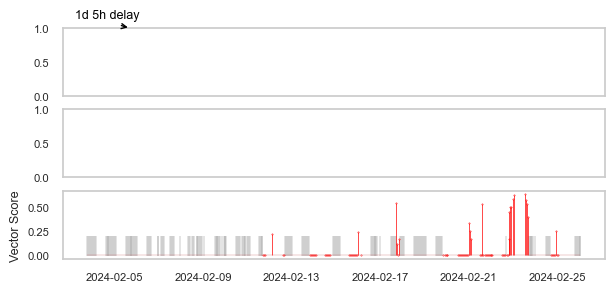

In [357]:
bv_color = "#a2c662"
ai_color = "#184EAD"
elog_color = "#117347"
vector_color = "red"

# predictions_color = '#43aa99'


fig, axes = plt.subplots(3, 1, figsize=(7, 3), sharex=True)

ax = axes[0]
ax2 = axes[1]
ax3 = axes[2]
# twin1 = ax.twinx()
# twin2 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
# twin2.spines.right.set_position(("axes", 1.1))
# twin2.set_ylim(-0.1,2)
# twin2.set_yticks([0,1])

annots = annotate_notes(ax, elog_hauls, text_xy=(-40, 7), var=10)

# # TOP ax = Elog plot
# sns.lineplot(x = 'utc_start_datetime', y = 'elog_haul', data = ai_counts_elog.loc[ai_counts_elog['unused_elog']==False], ax = ax, label = 'Elog Included', color =elog_color,  lw = 1, )
# sns.lineplot(x = 'utc_start_datetime', y = 'elog_haul', data = ai_counts_elog.loc[(ai_counts_elog['unused_elog']) | (ai_counts_elog['elog_haul']==0)], ax = ax, label = 'Elog Excluded', linestyle = '--', color =elog_color, lw = 1)
# # sns.lineplot(x = 'utc_start_datetime', y = 'elog_haul', data = ai_counts_elog, ax = ax, label = 'Elog Excluded', linestyle = '--', color =elog_color, lw = 1)
# ax.set_ylabel('Elog Haul')
# ax.set_ylim(-0.1, 2)
# ax.set_yticks([0,1])


# # MIDDLE ax2 = AI catches
# sns.lineplot(x = 'utc_start_datetime', y = catch_col, data = ai_counts_elog, ax = ax2, label = 'AI Counts', color =ai_color, lw = 1)
# ax2.set_ylabel('AI Count')

# BOTTOM ax3 = vector schore
# sns.lineplot(x = 'datetime', y= 'score', data = df_vector, ax = ax3, label = 'vector_score', color = vector_color, marker = 'o', markersize = 5, lw = 1)
ax3.vlines(
    df_vector_nulls["datetime"],
    ymin=-0.01,
    ymax=0.2,
    color="grey",
    linewidth=0.3,
    label="Null Score",
)
markerline, stemlines, baseline = ax3.stem(
    df_vector["datetime"], df_vector["score"], linefmt=vector_color, label="Vector Score"
)
stemlines.set_linewidths(0.5)
baseline.set_linewidth(0.2)
markerline.set_markersize(0.3)
ax3.set_ylabel("Vector Score")

In [349]:
df_vector_nulls = df_vector.loc[df_vector["score"].isna()]

In [347]:
df_vector["score"].isna()

0      False
1      False
2      False
3       True
4       True
       ...  
267    False
268    False
269     True
270     True
271     True
Name: score, Length: 272, dtype: bool